In [71]:
!pip install pyforest

In [72]:
from pyforest import *

import warnings
warnings.filterwarnings('ignore')  #, category=DeprecationWarning)

In [73]:
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',100)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
# path = 'D:/Moringa/projos/datathons/Zindi/predict the prices of houses in Nigeria/'
path = '/content/'
train = pd.read_csv(path + 'Housing_dataset_train.csv')
test = pd.read_csv(path + 'Housing_dataset_test.csv')
sample_submission = pd.read_csv(path + 'Sample_submission.csv')

display(train.head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,ID,loc,title,bedroom,bathroom,parking_space,price
0,3583,Katsina,Semi-detached duplex,2.0,2.0,1.0,1149999.565
1,2748,Ondo,Apartment,NaN,2.0,4.0,1672416.689
2,9261,Ekiti,NaN,7.0,5.0,NaN,3364799.814
3,2224,Anambra,Detached duplex,5.0,2.0,4.0,2410306.756
4,10300,Kogi,Terrace duplex,NaN,5.0,6.0,2600700.898


In [75]:
print(f'We have {train.shape[0]} rows and {train.shape[1]} columns in the train dataset')

We have 14000 rows and 7 columns in the train dataset


In [76]:
print(f'We have {test.shape[0]} rows and {test.shape[1]} columns in the test dataset')

We have 6000 rows and 6 columns in the test dataset


In [77]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,14000.0,4.862700e+03,3.818348e+03,0.00,1.672750e+03,3.527000e+03,8011.250,12999.00
bedroom,12201.0,4.308171e+00,2.441165e+00,1.00,2.000000e+00,4.000000e+00,6.000,9.00
bathroom,12195.0,3.134235e+00,2.035950e+00,1.00,1.000000e+00,2.000000e+00,5.000,7.00
parking_space,12189.0,3.169825e+00,1.599415e+00,1.00,2.000000e+00,3.000000e+00,4.000,6.00
price,14000.0,2.138082e+06,1.083057e+06,431967.29,1.393990e+06,1.895223e+06,2586699.494,16568486.16


In [78]:
train.isnull().sum()

ID                  0
loc              1813
title            1722
bedroom          1799
bathroom         1805
parking_space    1811
price               0
dtype: int64

In [79]:

def handle_missing_values(train):
    # Filling missing 'loc' values with the most frequent location
    most_frequent_location = train['loc'].mode().values[0]
    train['loc'].fillna(most_frequent_location, inplace=True)

    # Filling missing 'title' values with the most frequent title
    most_frequent_title = train['title'].mode().values[0]
    train['title'].fillna(most_frequent_title, inplace=True)

    # Filling missing 'bedroom' values with the median number of bedrooms
    median_bedroom = train['bedroom'].median()
    train['bedroom'].fillna(median_bedroom, inplace=True)
    # convert to int
    train['bedroom']=train['bedroom'].astype(int)

    # Filling missing 'bathroom' values with the median number of bathrooms
    median_bathroom = train['bathroom'].median()
    train['bathroom'].fillna(median_bathroom, inplace=True)
    # convert to int
    train['bathroom']=train['bathroom'].astype(int)

    # Filling missing 'parking_space' values with the median number of parking spaces
    median_parking_space = train['parking_space'].median()
    train['parking_space'].fillna(median_parking_space, inplace=True)
    # convert to int
    train['parking_space']=train['parking_space'].astype(int)

    # convert price to int
    train['price'] = train['price'].astype(int)

    return train

train = handle_missing_values(train)

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             14000 non-null  int64 
 1   loc            14000 non-null  object
 2   title          14000 non-null  object
 3   bedroom        14000 non-null  int64 
 4   bathroom       14000 non-null  int64 
 5   parking_space  14000 non-null  int64 
 6   price          14000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 765.8+ KB


In [81]:
train.isnull().sum()

ID               0
loc              0
title            0
bedroom          0
bathroom         0
parking_space    0
price            0
dtype: int64

In [82]:
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

In [83]:
train.head()

,loc,title,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2,2,1,1149999
1,Ondo,Apartment,4,2,4,1672416
2,Ekiti,Flat,7,5,3,3364799
3,Anambra,Detached duplex,5,2,4,2410306
4,Kogi,Terrace duplex,4,5,6,2600700


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: >

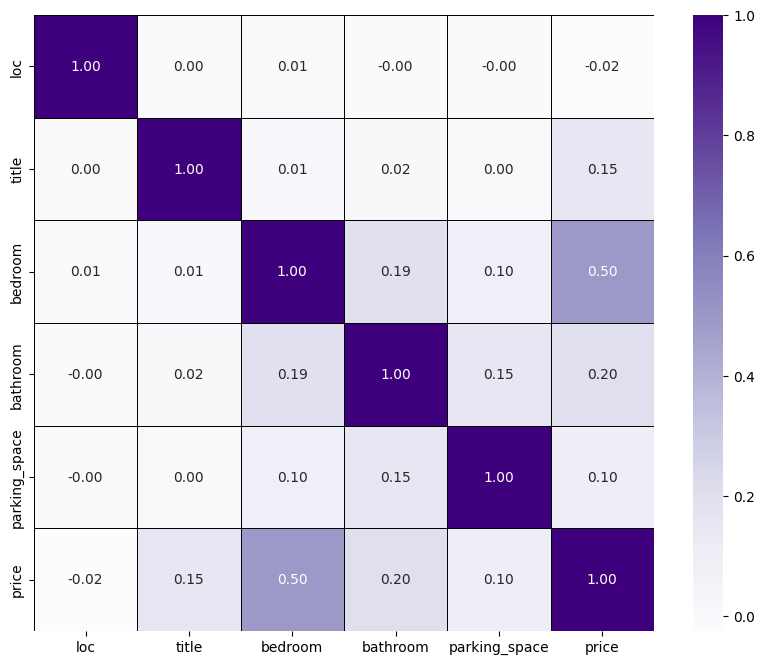

In [68]:
# check for correlation

# Plotting the heatmap of correlation between features
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap='Purples', linewidth=0.5, linecolor='black')

# Modelling

In [87]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


# Separate target variable (y) and features (X)
y = train['price']
X = train.drop(['price'], axis=1)

# Define models
models = {
    'LightGBM': lgb.LGBMRegressor(objective='regression', random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Cat Boost': CatBoostRegressor(random_state=42, silent=True)
}

# Create pipelines for each model
pipelines = {}
for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocess', ColumnTransformer([
            ('num', StandardScaler(), ['bedroom', 'bathroom', 'parking_space']),
            ('cat', 'passthrough', ['loc', 'title'])
        ])),
        ('model', model)
    ])
    pipelines[model_name] = pipeline

# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate each model
for model_name, pipeline in pipelines.items():
    pipeline.fit(X_train_split, y_train_split)
    y_val_pred = pipeline.predict(X_val_split)
    val_rmse = mean_squared_error(y_val_split, y_val_pred, squared=False)
    print(f"{model_name} Validation RMSE: {val_rmse}")

# Choose the best model based on the validation RMSE and retrain on the entire training data
best_model_name = 'XGBoost'  # Replace this with the model that performs the best based on the validation RMSE
best_model_pipeline = pipelines[best_model_name]
best_model_pipeline.fit(X, y)

# Now your best model is trained on the entire training data and ready for predictions


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71
[LightGBM] [Info] Number of data points in the train set: 11200, number of used features: 5
[LightGBM] [Info] Start training from score -0.002224
LightGBM Validation RMSE: 0.5437052540088749
Random Forest Validation RMSE: 0.6152890887454358
XGBoost Validation RMSE: 0.5486220760496249
Cat Boost Validation RMSE: 0.5392748809673547


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bedroom', 'bathroom',
                                                   'parking_space']),
                                                 ('cat', 'passthrough',
                                                  ['loc', 'title'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=Fals...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=42, ...))])